In [6]:
import os
import json
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [7]:
class MissingPartsDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, image_names, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_names = image_names

        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)

        all_parts = set()
        for ann in self.annotations.values():
            for item in ann:
                all_parts.add(item['part_name'])
        self.part_to_id = {part: i+1 for i, part in enumerate(sorted(all_parts))}
        self.id_to_part = {v: k for k, v in self.part_to_id.items()}

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, image_name)
        img = Image.open(img_path).convert("RGB")

        ann_list = self.annotations.get(image_name, [])
        boxes, labels = [], []

        for part in ann_list:
            bbox = part['absolute_bounding_box']
            x_min, y_min = bbox['left'], bbox['top']
            x_max = x_min + bbox['width']
            y_max = y_min + bbox['height']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(self.part_to_id[part['part_name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_names)

In [8]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

def visualize_prediction(image, pred, labels_map, threshold=0.5):
    image = F.to_pil_image(image.cpu())
    draw = ImageDraw.Draw(image)

    boxes = pred['boxes']
    labels = pred['labels']
    scores = pred['scores']

    for i in range(len(boxes)):
        if scores[i] >= threshold:
            box = boxes[i].tolist()
            label = labels_map[labels[i].item()]
            draw.rectangle(box, outline='red', width=3)
            draw.text((box[0], box[1]), f"{label} ({scores[i]:.2f})", fill='red')

    return image

In [10]:
# Paths
annotation_file = '../DelftBikes/final_annotations.json'
image_dir = '../DelftBikes/train/'

# Load and split data
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
image_names = sorted(list(annotations.keys()))

# Split
train_imgs = image_names[:20]
test_imgs = image_names[-10:]

# Create dataset and dataloaders
train_dataset = MissingPartsDataset(image_dir, annotation_file, train_imgs, transforms=F.to_tensor)
test_dataset = MissingPartsDataset(image_dir, annotation_file, test_imgs, transforms=F.to_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

num_classes = len(train_dataset.part_to_id) + 1

TypeError: string indices must be integers, not 'str'

In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

model.train()
for epoch in range(5):
    running_loss = 0.0
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss:.4f}")

[Epoch 1] Loss: 28.0928
[Epoch 2] Loss: 21.6506
[Epoch 3] Loss: 19.6981
[Epoch 4] Loss: 17.4983
[Epoch 5] Loss: 14.8727


In [ ]:
# Evaluation helper
from torchvision.ops import box_iou

def calculate_metrics(pred, target, iou_threshold=0.5):
    pred_boxes = pred['boxes']
    gt_boxes = target['boxes']

    if len(pred_boxes) == 0:
        return 0, 0, len(gt_boxes)

    ious = box_iou(pred_boxes, gt_boxes)
    matched_gt = set()
    true_positives = 0

    for i in range(len(pred_boxes)):
        if ious[i].max() > iou_threshold:
            gt_idx = ious[i].argmax().item()
            if gt_idx not in matched_gt:
                true_positives += 1
                matched_gt.add(gt_idx)

    false_positives = len(pred_boxes) - true_positives
    false_negatives = len(gt_boxes) - true_positives

    return true_positives, false_positives, false_negatives

In [ ]:
# Evaluate on training set
print("\n🔍 Evaluating on Training Set...")
model.eval()
train_tp, train_fp, train_fn = 0, 0, 0

with torch.no_grad():
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(imgs)

        for pred, target in zip(predictions, targets):
            tp, fp, fn = calculate_metrics(pred, target)
            train_tp += tp
            train_fp += fp
            train_fn += fn

train_precision = train_tp / (train_tp + train_fp + 1e-6)
train_recall = train_tp / (train_tp + train_fn + 1e-6)

print(f"📈 Training Precision: {train_precision:.4f}")
print(f"📈 Training Recall:    {train_recall:.4f}")


🔍 Evaluating on Training Set...
📈 Training Precision: 0.1520
📈 Training Recall:    0.9157



🔍 Evaluating on Test Set...


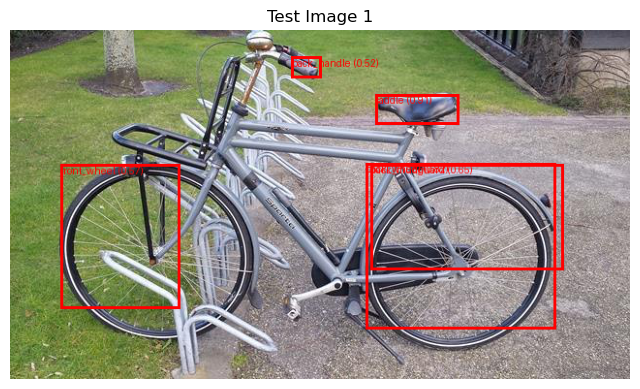

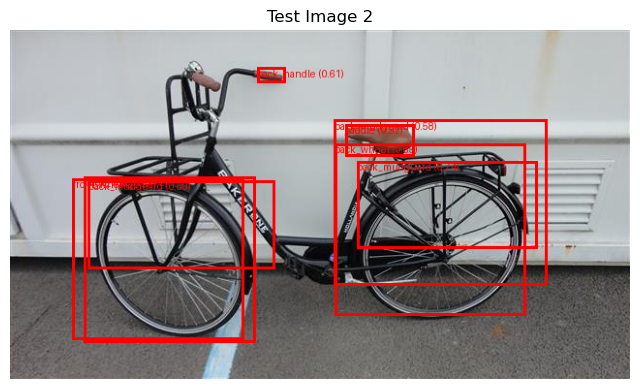

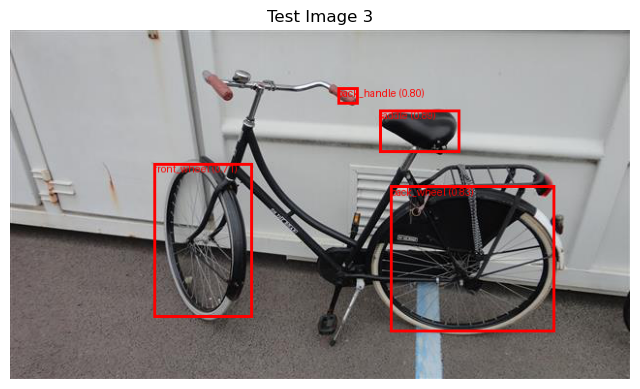

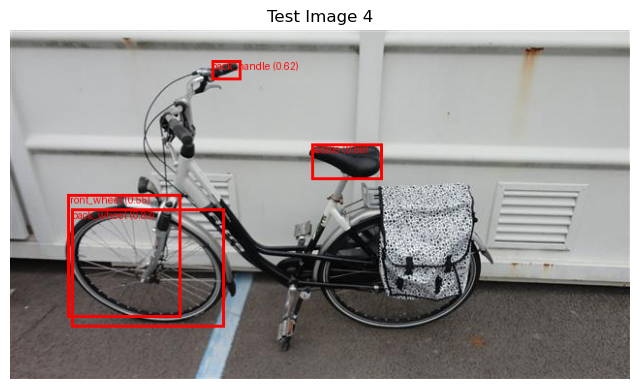

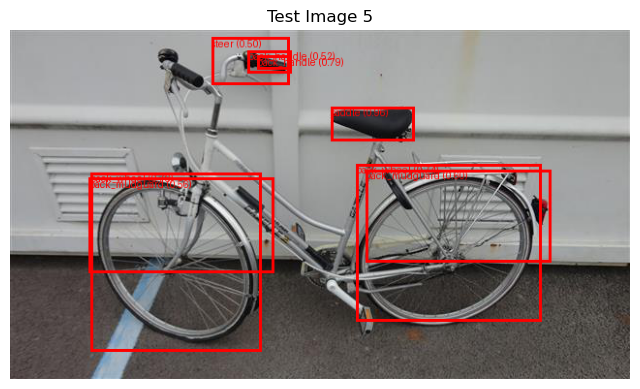

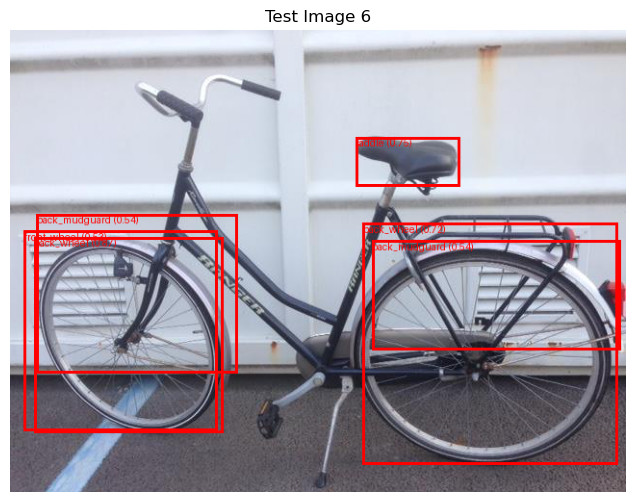

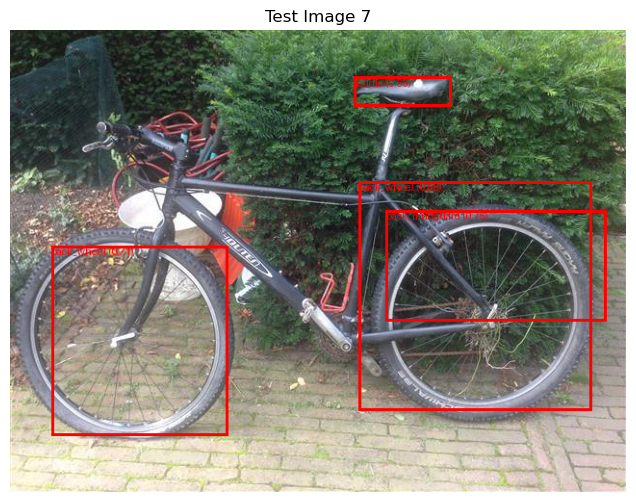

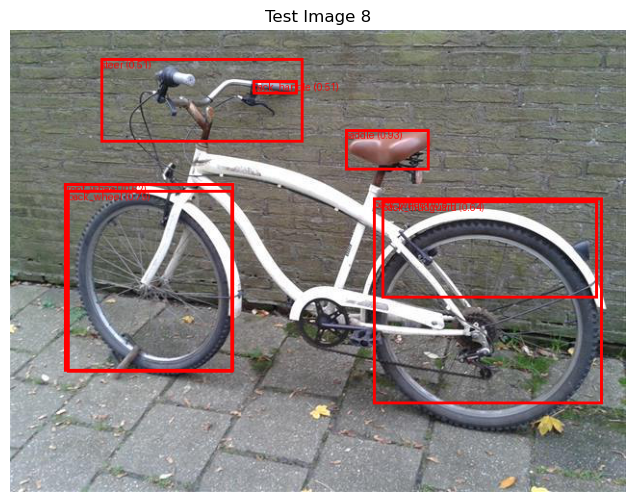

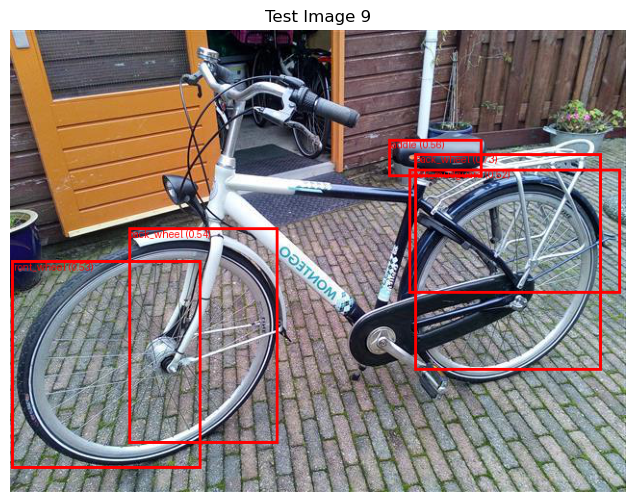

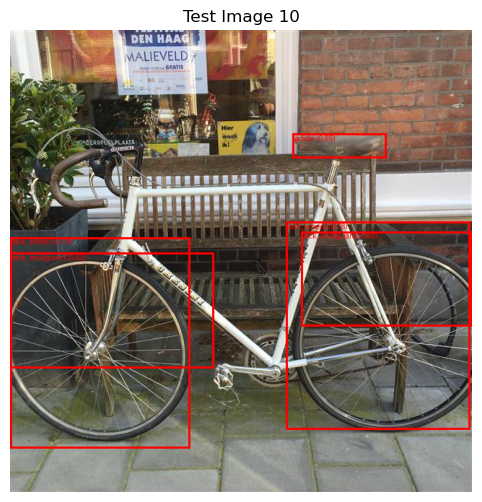

📈 Test Precision: 0.1170
📈 Test Recall:    0.7006


In [ ]:
# Evaluate on test set
print("\n🔍 Evaluating on Test Set...")
test_tp, test_fp, test_fn = 0, 0, 0

model.eval()
with torch.no_grad():
    for i, (imgs, targets) in enumerate(test_loader):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(imgs)

        img = visualize_prediction(imgs[0], predictions[0], test_dataset.id_to_part, threshold=0.5)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Test Image {i+1}")
        plt.axis("off")
        plt.show()

        tp, fp, fn = calculate_metrics(predictions[0], targets[0])
        test_tp += tp
        test_fp += fp
        test_fn += fn

test_precision = test_tp / (test_tp + test_fp + 1e-6)
test_recall = test_tp / (test_tp + test_fn + 1e-6)

print(f"📈 Test Precision: {test_precision:.4f}")
print(f"📈 Test Recall:    {test_recall:.4f}")